Os dados do arquivo Brain, em anexo, referem-se ao peso do cérebro (g), tamanho da cabeça (cm3) de 237 adultos, identificados por sexo e grupo etário. O estudo teve por objetivo verificar se:

1) Há diferença no peso cerebral entre os sexos? E entre os grupos etários? ([TESTE DE HIPÓTESE] H0: há diferença / Ha: não há diferença)

2) O tamanho da cabeça é preditor do peso cerebral e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários? (Regressão Linear)

3) Estime o peso médio do cérebro de homens e de mulheres (pontual e intervalar). (estimação de parâmetros)

Interprete seus resultados e verifique se as suposições dos métodos são adequadas a estes dados.

Se uma das suas respostas (aos itens 1, 2 ou 3) aplicar, além da estatística clássica, também a bayesiana (de maneira adequada, claro), sua nota será acrescida de 1 ponto (ou seja, sua prova fica valendo 11 pontos).

### IMPORTAÇÃO DAS BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.api as sms

### LEITURA DO ARQUIVO E AJUSTE NAS COLUNAS

In [2]:
# LEITURA DO ARQUIVO "BRAIN.CSV"
brain = pd.read_csv('Brain.csv')
# AJUSTE NO NOME DAS COLUNAS PARA MINUSCULO
brain.columns = map(str.lower, brain.columns)

### CRIAÇÃO DE NOVAS FEATURES 

In [3]:
# CRIAÇÃO DE NOVA COLUNA COM A SEGMENTAÇÃO DA IDADE PELO SEXO MASCULINO
brain['homem_acima45'] = [1 if age == 1 and men == 1 else 0 for age, men in zip(brain['acima45'], brain['homem'])]

# CRIAÇÃO DE NOVA COLUNA COM A IDENTIFICAÇÃO DO SEXO FEMININO
brain['mulher'] = [1 if woman == 0 else 0 for woman in brain['homem']]

# CRIAÇÃO DE NOVA COLUNA COM A IDENTIFICAÇÃO GENERO
brain['genero'] = ['F' if gender == 0 else 'M' for gender in brain['homem']]

# CRIAÇÃO DE NOVA COLUNA COM A SEGMENTAÇÃO DA IDADE PELO SEXO FEMININO
brain['mulher_acima45'] = [1 if age == 1 and woman == 1 else 0 for age, woman in zip(brain['acima45'], brain['mulher'])]

# AJUSTE NA ORDEM DAS COLUNAS
brain = brain.reindex(columns=['homem', 'homem_acima45', 'mulher', 'mulher_acima45', 'genero', 'tamanho', 'peso', 'acima45'])

In [4]:
brain.head()

,homem,homem_acima45,mulher,mulher_acima45,genero,tamanho,peso,acima45
0,1,0,0,0,M,4512,1530,0
1,1,0,0,0,M,3738,1297,0
2,1,0,0,0,M,4261,1335,0
3,1,0,0,0,M,3777,1282,0
4,1,0,0,0,M,4177,1590,0


### ANÁLISE DESCRITIVA DOS VALORES DAS COLUNAS "TAMANHO" E "PESO"

In [5]:
brain[['tamanho', 'peso']].describe()

,tamanho,peso
count,237.000000,237.000000
mean,3633.991561,1282.873418
std,365.261422,120.340446
min,2720.000000,955.000000
25%,3389.000000,1207.000000
50%,3614.000000,1280.000000
75%,3876.000000,1350.000000
max,4747.000000,1635.000000


### VISUALIZAÇÃO DA DISTRIBUIÇÃO E CORRELAÇÃO ENTRE AS VARIÁVEIS "TAMANHO" E "PESO"

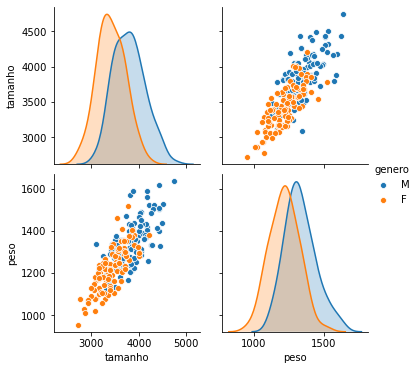

In [6]:
sns.pairplot(brain, vars=['tamanho', 'peso'], hue='genero');

# EXERCÍCIO 1:
## 1) Há diferença no peso cerebral entre os sexos? E entre os grupos etários?

### Criação das variáveis auxiliares<br>
São criadas as variáveis que serão utilizadas durante os testes de Hipótese:<br>
- **homem_peso**: valores da variável **peso** quando o sexo for Masculino
- **mulher_peso**: valores da variável **peso** quando o sexo for Feminino
<br><br>
- **acima45_peso**: valores da variável **peso** quando a faixa etária for Acima de 45 Anos
- **abaixo45_peso**: valores da variável **peso** quando a faixa etária for Abaixo de 45 Anos

In [7]:
homem_peso =  np.array(brain.loc[brain['homem']==1, 'peso'])
mulher_peso =  np.array(brain.loc[brain['mulher']==1, 'peso'])

acima45_peso =  np.array(brain.loc[brain['acima45']==1, 'peso'])
abaixo45_peso =  np.array(brain.loc[brain['acima45']==0, 'peso'])

### Definição das Hipóteses:
Definição das Hipóteses a serem testadas:<br>
- **$H_{0}$**: *NÃO HÁ* diferença entre os pesos cerebrais entre os sexos<br>
- **$H_{a}$**: *HÁ* diferença entre os pesos cerebrais entre os sexos
<br>
#### Alpha ($\alpha$) definido: **0.05**

### Análise descritiva da variável *peso* para o sexo Masculino

In [8]:
brain.loc[brain['homem']==1, 'peso'].describe().rename_axis(['medida']).reset_index()

,medida,peso
0,count,134.000000
1,mean,1331.858209
2,std,108.933390
3,min,1120.000000
4,25%,1252.750000
5,50%,1313.500000
6,75%,1400.000000
7,max,1635.000000


### Análise probabilistica de normalidade da variável *peso* para o sexo Masculino
Análise realizada com a aplicação dos seguintes métodos:<br>
- Q-Q Plot: Análise visual para checar a suposição da distribuição dos dados para a variável de *Peso Masculino*
- Shapiro Wilk: Teste de normalidade a partir da comparação do *p_valor* resultante do teste

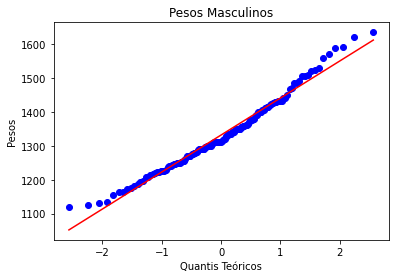

In [9]:
stats.probplot(homem_peso, plot=plt)

plt.title('Pesos Masculinos')
plt.xlabel('Quantis Teóricos')
plt.ylabel('Pesos')

plt.show()

In [10]:
alpha = 0.05
_, p_value = stats.shapiro(homem_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição é Normal.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição NÃO é Normal.')

Com p_valor de 0.029 assumimos que a distribuição NÃO é Normal.


### Análise descritiva da variável *peso* para o sexo Feminino

In [11]:
brain.loc[brain['mulher']==1, 'peso'].describe().rename_axis(['medida']).reset_index()

,medida,peso
0,count,103.000000
1,mean,1219.145631
2,std,103.829933
3,min,955.000000
4,25%,1146.000000
5,50%,1220.000000
6,75%,1290.000000
7,max,1520.000000


### Análise probabilistica de normalidade da variável *peso* para o sexo Feminino
Análise realizada com a aplicação dos seguintes métodos:<br>
- Q-Q Plot: Análise visual para checar a suposição da distribuição dos dados para a variável de *Peso Feminino*
- Shapiro Wilk: Teste de normalidade a partir da comparação do *p_valor* resultante do teste

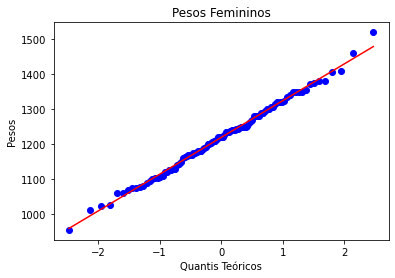

In [12]:

stats.probplot(mulher_peso, plot=plt)

plt.title('Pesos Femininos')
plt.xlabel('Quantis Teóricos')
plt.ylabel('Pesos')

plt.show()

In [13]:
alpha = 0.05
_, p_value = stats.shapiro(mulher_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição é Normal.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição NÃO é Normal.')

Com p_valor de 0.992 assumimos que a distribuição é Normal.


### Análise probabilistica para a comparação das Variâncias das amostras
Análise realizada com a aplicação do seguinte método:<br>
- Levene: Teste que avalia $H_{0}$ de que as variáveis possuem a mesma Variância

In [14]:
_, p_value = stats.levene(homem_peso, mulher_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras possuem a mesma Variância.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras NÃO possuem a mesma Variância.')

Com p_valor de 0.767 assumimos que as Amostras possuem a mesma Variância.


### Análise probabilistica sobre a Independência das variáveis
Análise realizada com a aplicação do seguinte método:<br>
- Correlação de Pearson: Teste que avalia $H_{0}$ de que as variáveis são independentes<br>
<br>
Como as amostras iniciais possuem tamanhos diferentes, extraímos dessa variável novas amostras aleatórias contendo 100 observações e sobre essa nova amostra foi aplicado o método mencionado.

In [15]:
alpha = 0.05
s_homem_peso = np.random.choice(homem_peso, 100)
s_mulher_peso = np.random.choice(mulher_peso, 100)

_, p_value = stats.pearsonr(s_homem_peso, s_mulher_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras são Independentes.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras NÃO são Independentes.')

Com p_valor de 0.533 assumimos que as Amostras são Independentes.


### Análise probabilistica para avaliação das Hipóteses definidas
Análise realizada com a aplicação do seguinte método:<br>
- T-Student: Teste que, a partir da análise do *p_valor*, avalia a aceitação ou rejeição de $H_{0}$.

In [16]:
_, p_value = stats.ttest_ind(homem_peso, mulher_peso, equal_var = True)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 5)} assumimos que NÃO HÁ diferença entre os pesos cerebrais entre os sexos.')
else:
    print(f'Com p_valor de {round(p_value, 5)} assumimos que HÁ diferença entre os pesos cerebrais entre os sexos.')

Com p_valor de 0.0 assumimos que HÁ diferença entre os pesos cerebrais entre os sexos.


### Análise descritiva da variável *peso* para a faixa etária acima de 45 anos

In [17]:
brain.loc[brain['acima45']==1, 'peso'].describe()

count     127.000000
mean     1263.937008
std       120.925712
min       955.000000
25%      1180.000000
50%      1250.000000
75%      1332.500000
max      1620.000000
Name: peso, dtype: float64

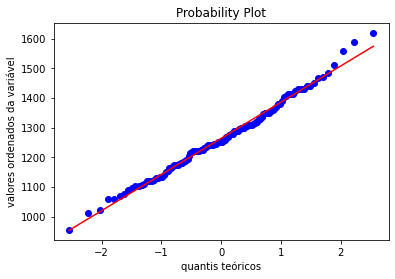

In [73]:
stats.probplot(acima45_peso, plot=plt)
plt.xlabel('quantis teóricos')
plt.ylabel('valores ordenados da variável')
plt.show()

In [19]:
alpha = 0.05
_, p_value = stats.shapiro(acima45_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição é Normal.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição NÃO é Normal.')

Com p_valor de 0.655 assumimos que a distribuição é Normal.


### Análise descritiva da variável *peso* para a faixa etária abaixo de 45 anos

In [20]:
brain.loc[brain['acima45']==0, 'peso'].describe()

count     110.000000
mean     1304.736364
std       116.409959
min      1027.000000
25%      1227.500000
50%      1301.000000
75%      1370.750000
max      1635.000000
Name: peso, dtype: float64

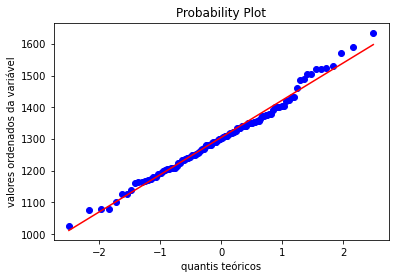

In [21]:
stats.probplot(abaixo45_peso, plot=plt)
plt.xlabel('quantis teóricos')
plt.ylabel('valores ordenados da variável')
plt.show()

In [22]:
alpha = 0.05
_, p_value = stats.shapiro(abaixo45_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição é Normal.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição NÃO é Normal.')

Com p_valor de 0.422 assumimos que a distribuição é Normal.


### Análise probabilistica para a comparação das Variâncias das amostras
Análise realizada com a aplicação do seguinte método:<br>
- Levene: Teste que avalia $H_{0}$ de que as variáveis possuem a mesma Variância

In [23]:
_, p_value = stats.levene(acima45_peso, abaixo45_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras possuem a mesma Variância.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras NÃO possuem a mesma Variância.')

Com p_valor de 0.692 assumimos que as Amostras possuem a mesma Variância.


### Análise probabilistica sobre a Independência das variáveis
Análise realizada com a aplicação do seguinte método:<br>
- Correlação de Pearson: Teste que avalia $H_{0}$ de que as variáveis são independentes<br>
<br>
Como as amostras iniciais possuem tamanhos diferentes, extraímos dessa variável novas amostras aleatórias contendo 100 observações e sobre essa nova amostra foi aplicado o método mencionado.

In [24]:
s_acima45_peso = np.random.choice(acima45_peso, 100)
s_abaixo45_peso = np.random.choice(abaixo45_peso, 100)

_, p_value = stats.pearsonr(s_acima45_peso, s_abaixo45_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras são Independentes.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras NÃO são Independentes.')

Com p_valor de 0.388 assumimos que as Amostras são Independentes.


### Análise probabilistica para avaliação das Hipóteses definidas
Análise realizada com a aplicação do seguinte método:<br>
- T-Student: Teste que, a partir da análise do *p_valor*, avalia a aceitação ou rejeição de $H_{0}$.

In [25]:
_, p_value = stats.ttest_ind(acima45_peso, abaixo45_peso, equal_var = True)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 5)} assumimos que NÃO HÁ diferença entre os pesos cerebrais entre as faixa etárias.')
else:
    print(f'Com p_valor de {round(p_value, 5)} assumimos que HÁ diferença entre os pesos cerebrais entre as faixa etárias.')

Com p_valor de 0.00896 assumimos que HÁ diferença entre os pesos cerebrais entre as faixa etárias.


# RESPOSTA 1:
## HÁ DIFERENÇA ENTRE OS PESOS CEREBRAIS QUANDO AVALIADO O SEXO E AS FAIXAS ETÁRIAS
---

# EXERCÍCIO 2:
2) O tamanho da cabeça é preditor do peso cerebral e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários?

In [75]:
brain['tamanho_centrado'] = brain['tamanho'] - np.mean(brain['tamanho'])

brain['tamanho_padronizado'] = (brain['tamanho'] - np.mean(brain['tamanho']))/np.std(brain['tamanho'])

In [76]:
brain.head()

,homem,homem_acima45,mulher,mulher_acima45,genero,tamanho,peso,acima45,tamanho_ajustado,tamanho_padronizado,tamanho_centrado
0,1,0,0,0,M,4512,1530,0,878.008439,2.408868,878.008439
1,1,0,0,0,M,3738,1297,0,104.008439,0.285353,104.008439
2,1,0,0,0,M,4261,1335,0,627.008439,1.720235,627.008439
3,1,0,0,0,M,3777,1282,0,143.008439,0.392352,143.008439
4,1,0,0,0,M,4177,1590,0,543.008439,1.489776,543.008439


### Regressão Linear
Análise realizada com a aplicação do seguinte método:<br>
- OLS (Ordinary Least Square / Método dos Mínimos Quadrados)

In [82]:
mod = ols('peso ~ homem + acima45 + tamanho + tamanho_centrado + mulher',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        23:54:26   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0001   4.35e-06     29.630      0.000       0

In [83]:
y, X = dmatrices('peso ~ homem + acima45 + tamanho + tamanho_centrado', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor          features
0    0.000000         Intercept
1    1.398371             homem
2    1.040419           acima45
3         inf           tamanho
4         inf  tamanho_centrado


### Retirado a variável *mulher* por ter o mesmo p_value que a variável *homem*

In [84]:
mod = ols('peso ~ homem + acima45 + tamanho + tamanho_centrado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        23:54:41   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0001   3.99e-06     31.876      0.000       0

In [85]:
y, X = dmatrices('peso ~ homem + acima45 + tamanho + tamanho_centrado', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor          features
0    0.000000         Intercept
1    1.398371             homem
2    1.040419           acima45
3         inf           tamanho
4         inf  tamanho_centrado


### Removido a variável de *tamanho_centrado* e alterado para *tamanho_padronizado* para avaliação

In [86]:
mod = ols('peso ~ homem + acima45 + tamanho + tamanho_padronizado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        23:56:50   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.9393      0.528      7.463      0.00

In [88]:
y, X = dmatrices('peso ~ homem + acima45 + tamanho + tamanho_padronizado', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor             features
0    0.000000            Intercept
1    1.398371                homem
2    1.040419              acima45
3         inf              tamanho
4         inf  tamanho_padronizado


### Removido a variável *tamanho* por apresentador o mesmo p_valor que a variável *tamanho_padronizado*

In [90]:
mod = ols('peso ~ homem + acima45 + tamanho_padronizado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        23:57:27   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1282.9713      8.703    147.412      0.00

## modelo selecionado abaixo:

In [91]:
mod = ols('peso ~ homem + homem_acima45 + tamanho_padronizado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     145.2
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           4.63e-53
Time:                        23:58:40   Log-Likelihood:                -1346.2
No. Observations:                 237   AIC:                             2700.
Df Residuals:                     233   BIC:                             2714.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1271.7430      7.740    164.308      0.00

# EXERCÍCIO 3
## 3) Estime o peso médio do cérebro de homens e de mulheres (pontual e intervalar).

In [60]:
homem_peso = brain.loc[brain['homem']==1, 'peso']
mulher_peso = brain.loc[brain['mulher']==1, 'peso']

Melhor mu: 1331.5726290516207
Estimativa intervalar para o Peso dos Homens:  (1313.2447792718747, 1350.4716386385733)


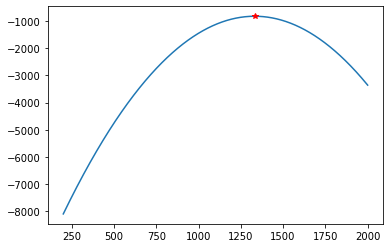

In [61]:
#Conhecendo a forma da função log-verossimilhança da amostra da distribuição Normal
# tomando os dados do peso dos homens, podemos fazer a estimativa da média:
def get_ll_normal(x, mu, sigma):
    return np.sum(np.log(stats.norm.pdf(x, mu, sigma)))

x = homem_peso # iguala x a variável "Media" 
sigma = np.std(x) # # parâmetro fixo, igualado ao desvio padrão amostral
theta = np.linspace(200, 2000, 2500) # parâmetro que vamos variar (mu)
f_theta1 = np.array([get_ll_normal(x, mu, sigma) for mu in theta])

i_best = np.argmax(f_theta1) # cálculo (numérico) do estimador de máxima verossimilhança (EMV) de mu
print('Melhor mu:', theta[i_best])
print("Estimativa intervalar para o Peso dos Homens: ",sms.DescrStatsW(homem_peso).tconfint_mean()) # IC para média de uma Normal (desvio padrão desconhecido)

plt.plot(theta, f_theta1)
plt.plot([theta[i_best]], [f_theta1[i_best]], 'r*'); # coloca uma estrelinha no maior valor (EMV)



Melhor mu: 1219.2076830732294
Estimativa intervalar para o Peso das Mulheres:  (1198.8531509366069, 1239.4381111993155)


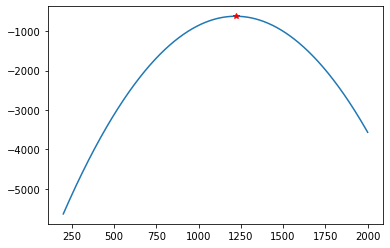

In [62]:
#Conhecendo a forma da função log-verossimilhança da amostra da distribuição Normal
# tomando os dados do peso dos homens, podemos fazer a estimativa da média:
def get_ll_normal(x, mu, sigma):
    return np.sum(np.log(stats.norm.pdf(x, mu, sigma)))

x = mulher_peso # iguala x a variável "Media" 
sigma = np.std(x) # # parâmetro fixo, igualado ao desvio padrão amostral
theta = np.linspace(200, 2000, 2500) # parâmetro que vamos variar (mu)
f_theta1 = np.array([get_ll_normal(x, mu, sigma) for mu in theta])

i_best = np.argmax(f_theta1) # cálculo (numérico) do estimador de máxima verossimilhança (EMV) de mu
print('Melhor mu:', theta[i_best])
print("Estimativa intervalar para o Peso das Mulheres: ",sms.DescrStatsW(mulher_peso).tconfint_mean()) # IC para média de uma Normal (desvio padrão desconhecido)

plt.plot(theta, f_theta1)
plt.plot([theta[i_best]], [f_theta1[i_best]], 'r*'); # coloca uma estrelinha no maior valor (EMV)
